# Equity Options Portfolio Optimization:
**Authors:** William Lester, Luke Rutherford, Dylan Kynoch, Henry Daniel \
**Start Date:** 4/17/2024 \
**Last Updated:** 4/19/2024

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import data_functions as dat_func, visualizations as vis
import yfinance as yf
from datetime import datetime
import QuantLib as ql
from scipy.optimize import minimize
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
start_date,end_date="2023-04-19",'2024-04-19'
start_date,end_date=pd.to_datetime(start_date),pd.to_datetime(end_date)
trade_dates=dat_func.get_trading_days(start_date,end_date)

#tickers = ['XOM', 'WMT', 'GPC', 'OXY', 'PM', 'NNI', 'FI', 'ATKR', 'VICI', 'ADBE', 'AMAT', 'STLD']
tickers = ['XOM', 'WMT', 'GPC','FI']
ex_stock='GPC'

[*********************100%%**********************]  4 of 4 completed


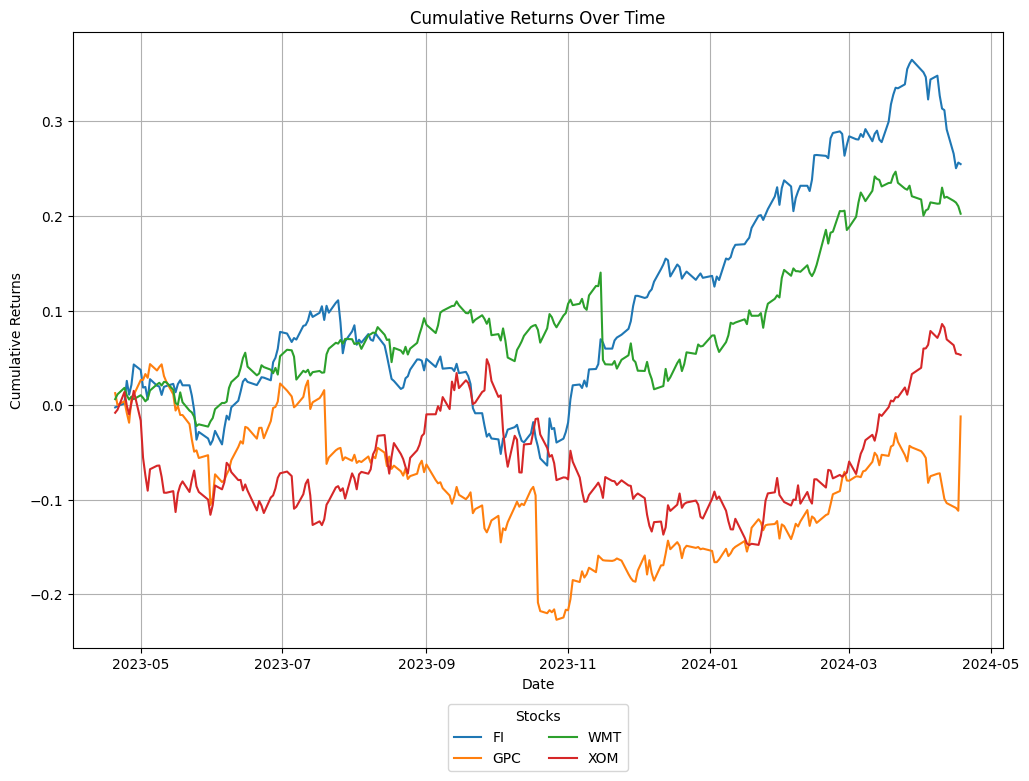

In [3]:
stock_df=dat_func.get_price_df(tickers,start_date,end_date)
returns_df=dat_func.get_log_returns(stock_df)
vis.plot_cumulative_returns(returns_df)

In [4]:
fred,poly=dat_func.connect_apis()
risk_free_rate=fred.get_series('GS10').iloc[-1]/100

In [5]:
init_weights,init_ret,init_std=dat_func.get_init_port(returns_df,risk_free_rate,leverage_limit=1)
init_weights=init_weights.round(3)
print('Initial Port Returns:',init_ret)
print('Initial Port Volatility:',init_std)
print('Initial Port Sharpe:',(init_ret-risk_free_rate)/init_std)
print('Optimal Weights:',dict(zip(returns_df.columns,init_weights)))

Initial Port Returns: 0.19352008317333286
Initial Port Volatility: 0.1117369184046942
Initial Port Sharpe: 1.3551481939470735
Optimal Weights: {'FI': 0.524, 'GPC': -0.081, 'WMT': 0.396, 'XOM': 0.0}


## Initial Portfolio Simulation:
### Geometric Brownian Motion: 

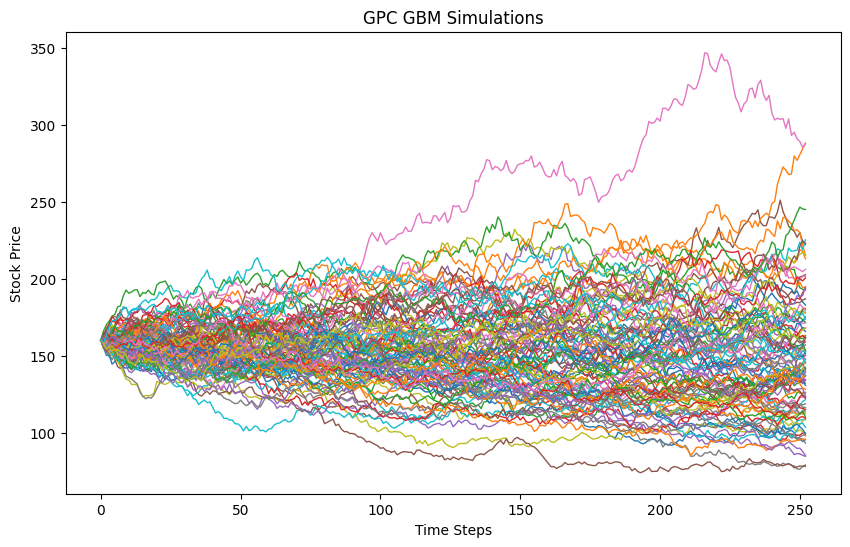

In [6]:
gpc_gbm=dat_func.simulate_gbm(stock_df[ex_stock][-1],returns_df.mean()[ex_stock]*252,returns_df.std()[ex_stock]*np.sqrt(252),1,N=100)
vis.plot_paths(gpc_gbm,f'{ex_stock} GBM',False)

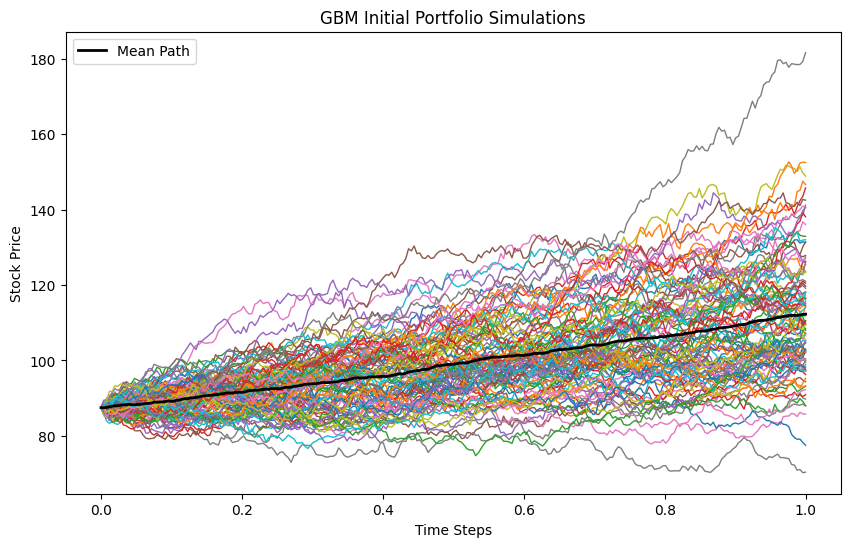

In [7]:
gbm_init_port=dat_func.simulate_gbm_portfolio(returns_df,stock_df,init_weights)
vis.plot_paths(gbm_init_port.iloc[:100],'GBM Initial Portfolio',True)

In [8]:
gbm_ret=(gbm_init_port.mean(axis=0).iloc[-1]-gbm_init_port.mean(axis=0).iloc[0])/gbm_init_port.mean(axis=0).iloc[0]
print(f'GBM Initial Portfolio Return: {round(gbm_ret*100,2)}%')

GBM Initial Portfolio Return: 28.32%


### Merton Jump Diffusion: 

In [9]:
# Estimate the number of jumps, mean jump, and vol of jumps
gpc_lambda_,gpc_m,gpc_v=dat_func.estimate_merton_params(returns_df[ex_stock])

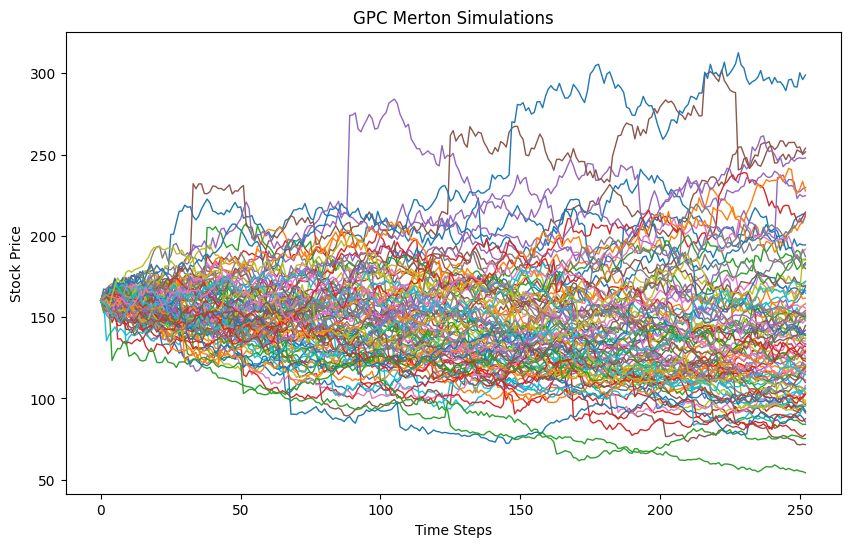

In [10]:
gpc_merton=dat_func.simulate_merton(stock_df[ex_stock][-1],returns_df.mean()[ex_stock]*252,returns_df.std()[ex_stock]*np.sqrt(252),1,gpc_lambda_,gpc_m,gpc_v,1/252,100)
vis.plot_paths(gpc_merton,f'{ex_stock} Merton')

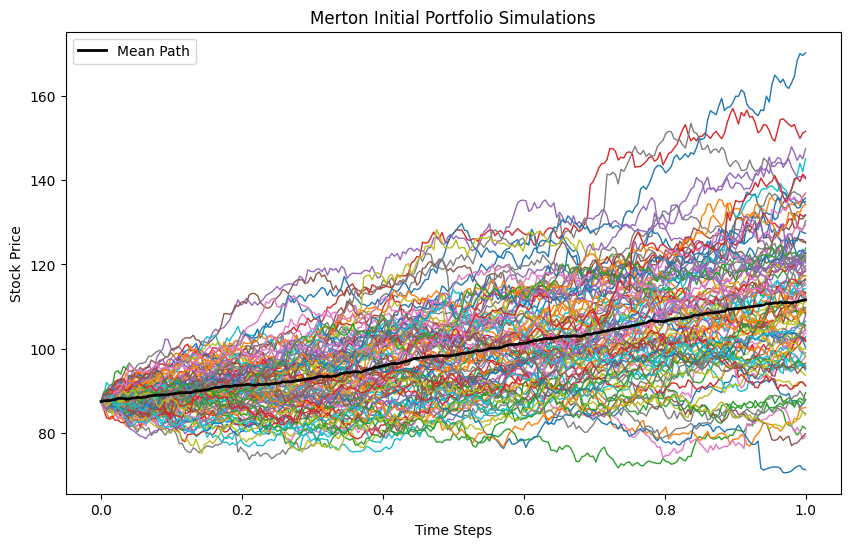

In [11]:
merton_init_port=dat_func.simulate_merton_portfolio(returns_df,stock_df,init_weights)
vis.plot_paths(merton_init_port.iloc[:100],'Merton Initial Portfolio',True)

In [12]:
merton_ret=(merton_init_port.mean(axis=0).iloc[-1]-merton_init_port.mean(axis=0).iloc[0])/merton_init_port.mean(axis=0).iloc[0]
print(f'Merton Initial Portfolio Return: {round(merton_ret*100,2)}%')

Merton Initial Portfolio Return: 27.53%


### Constant Elasticity of Variance (CEV): 

Estimated GPC CEV Parameters: mu=0.0003117124359647677, std=0.00024040160993540552, gamma=1.840744216920092


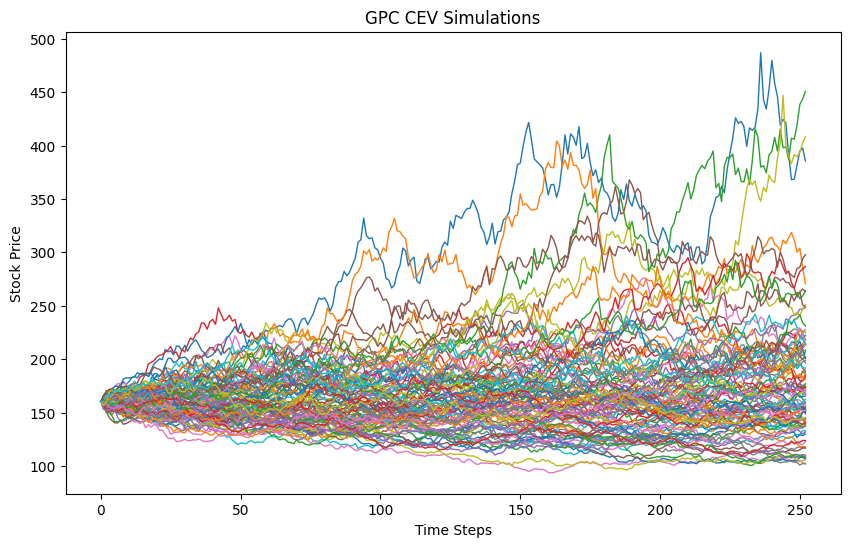

In [13]:
cev_ex_params=dat_func.estimate_cev_params(stock_series=stock_df[ex_stock])
simulated_prices = dat_func.simulate_cev(stock_df[ex_stock][-1],cev_ex_params[0]*252,cev_ex_params[1]*np.sqrt(252), gamma=cev_ex_params[2], T=1)
vis.plot_paths(simulated_prices[:100],f'{ex_stock} CEV')

Estimated FI CEV Parameters: mu=0.0008851478378471625, std=1.3013306383472245, gamma=0.00013760840503559407
Estimated GPC CEV Parameters: mu=0.0003117124359647677, std=0.00024040160993540552, gamma=1.840744216920092
Estimated WMT CEV Parameters: mu=0.0008522277861228081, std=0.0001745542011980164, gamma=2.0
Estimated XOM CEV Parameters: mu=0.00031380341624591396, std=0.008188759128425496, gamma=1.1079257087772652


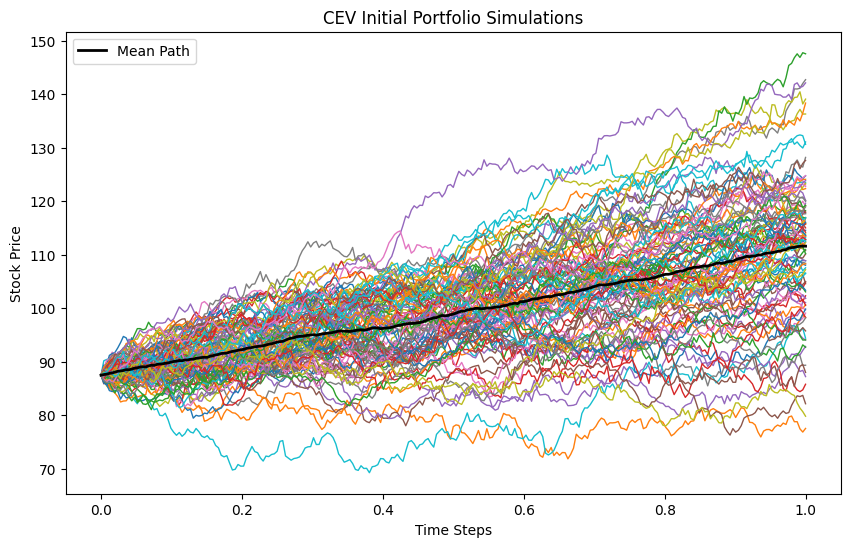

In [14]:
cev_init_port=dat_func.simulate_cev_portfolio(stock_df,init_weights)
vis.plot_paths(cev_init_port.iloc[:100],'CEV Initial Portfolio',True)

In [15]:
cev_ret=(cev_init_port.mean(axis=0).iloc[-1]-cev_init_port.mean(axis=0).iloc[0])/cev_init_port.mean(axis=0).iloc[0]
print(f'CEV Initial Portfolio Return: {round(cev_ret*100,2)}%')

CEV Initial Portfolio Return: 27.08%


### Heston Model:

In [16]:
def days_to_expiration(ticker, symbol):
    date_part = symbol[len(ticker):]  # Assumes date part starts right after the ticker
    exp_year = int(date_part[0:2]) + 2000
    exp_month = int(date_part[2:4])
    exp_day = int(date_part[4:6])
    return exp_day, exp_month, exp_year

def get_options_data(symbol):
    ticker = yf.Ticker(symbol)
    opts = ticker.option_chain()
    calls = opts.calls
    puts = opts.puts

    # Apply the days_to_expiration function and split its results into separate columns
    # Ensure each contractSymbol is passed with the ticker prefix known to be removed
    calls[['Day', 'Month', 'Year']] = calls['contractSymbol'].apply(lambda x: days_to_expiration(symbol, x)).apply(pd.Series)
    puts[['Day', 'Month', 'Year']] = puts['contractSymbol'].apply(lambda x: days_to_expiration(symbol, x)).apply(pd.Series)
    
    return calls, puts

In [17]:
def estimate_heston_params(ticker,risk_free_rate):
    calls,puts=get_options_data(ticker)
    today=ql.Date(end_date.day,end_date.month,end_date.year)
    calendar = ql.UnitedStates(ql.UnitedStates.NYSE)
    day_count = ql.Actual365Fixed()
    try:
        dividend_rate=yf.Ticker(ticker).info['dividendYield']
    except KeyError:
        dividend_rate=0

    spot_handle = ql.QuoteHandle(ql.SimpleQuote(stock_df[ticker].iloc[-1]))
    rate_handle = ql.YieldTermStructureHandle(ql.FlatForward(today, risk_free_rate, day_count))
    dividend_handle = ql.YieldTermStructureHandle(ql.FlatForward(today, dividend_rate, day_count))

    v0_init = 0.01  # initial variance
    kappa_init = 0.2  # rate of mean reversion
    theta_init = 0.02  # long-term variance
    sigma_init = 0.5  # volatility of volatility
    rho_init = -0.75  # correlation between the two Brownian motions

    process = ql.HestonProcess(rate_handle, dividend_handle, spot_handle, v0_init, kappa_init, theta_init, sigma_init, rho_init)
    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model,128)

    helpers = []
    options_data = [(calls, ql.Option.Call), (puts, ql.Option.Put)]

    for option_df, opt_type in options_data:
        for index, row in option_df.iterrows():
            strike = row['strike']
            mid_price = row['lastPrice']
            maturity_date = ql.Date(row['Day'], row['Month'], row['Year'])
            underlying=stock_df[ticker].asof(row['lastTradeDate'].strftime('%Y-%m-%d'))
            last_date=ql.Date(row['lastTradeDate'].day,row['lastTradeDate'].month,row['lastTradeDate'].year)
            t = maturity_date-last_date
            
            payoff = ql.PlainVanillaPayoff(opt_type, strike)
            exercise = ql.EuropeanExercise(maturity_date)
            helper = ql.HestonModelHelper(ql.Period(int(t), ql.Days), calendar, underlying, strike, ql.QuoteHandle(ql.SimpleQuote(mid_price)), rate_handle, dividend_handle)
            helper.setPricingEngine(engine)
            helpers.append(helper)

    cost_thresh=1.3
    helpers=[help for help in helpers if (np.abs(help.calibrationError())<cost_thresh)]


    for i, helper in enumerate(helpers):
        cost_pre = helper.calibrationError()
        #print(f"Pre-calibration cost for helper {i}: {cost_pre}")

    method = ql.LevenbergMarquardt()
    model.calibrate(helpers, method, ql.EndCriteria(1000, 500, 1e-8, 1e-8, 1e-8))

    theta, kappa, sigma, rho, v0 = model.params()
    print(f"Calibrated {ticker} parameters: theta={theta}, kappa={kappa}, sigma={sigma}, rho={rho}, v0={v0}")
    return theta, kappa, sigma, rho, v0

estimate_heston_params('XOM',risk_free_rate)

Calibrated XOM parameters: theta=0.07335012320947418, kappa=3.5383325919058817, sigma=0.16605373903341053, rho=-0.9999977783947803, v0=0.011464510375516648


(0.07335012320947418,
 3.5383325919058817,
 0.16605373903341053,
 -0.9999977783947803,
 0.011464510375516648)